# 06 – Model Evaluation

This notebook compares the performance of the trained models using various metrics and visualises the results with confusion matrices and ROC curves.


X_test shape: (10000, 14) sparse: True
y_test distribution:
label
0    0.5948
1    0.4052
Name: proportion, dtype: float64

Models found:
['Bagging_LR', 'ExtraTrees', 'HistGradientBoosting', 'LogisticRegression', 'RandomForest', 'Stacking', 'Stacking_Calibrated', 'Voting_Soft']
  [info] Built X_test_dense (float32) because a model requires dense input.

Final Evaluation Results:
                  Model InputUsed   ROC_AUC   LogLoss    PR_AUC  BestThr_F1  \
0           Voting_Soft     dense  0.820466  0.525700  0.753780    0.465446   
1            Bagging_LR    sparse  0.826605  0.503809  0.750604    0.354768   
2    LogisticRegression    sparse  0.826544  0.503184  0.750481    0.344985   
3            ExtraTrees    sparse  0.813410  0.554935  0.746753    0.488925   
4              Stacking     dense  0.824642  0.507445  0.743927    0.311048   
5          RandomForest    sparse  0.799270  0.581038  0.736714    0.524715   
6   Stacking_Calibrated     dense  0.818102  0.513154  0.734854  

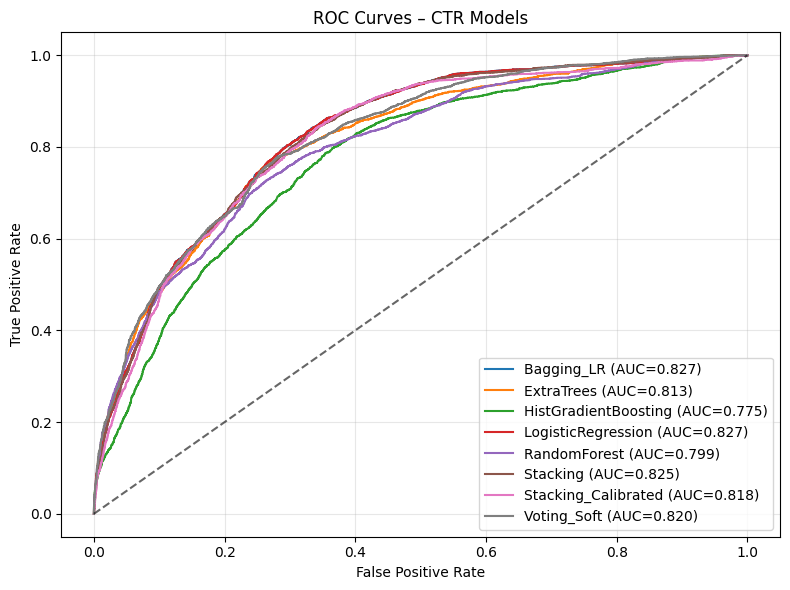

Saved figure: d:\projects\Ai\project_fusion_ecu\data\processed\figures_eval\roc_curves.png


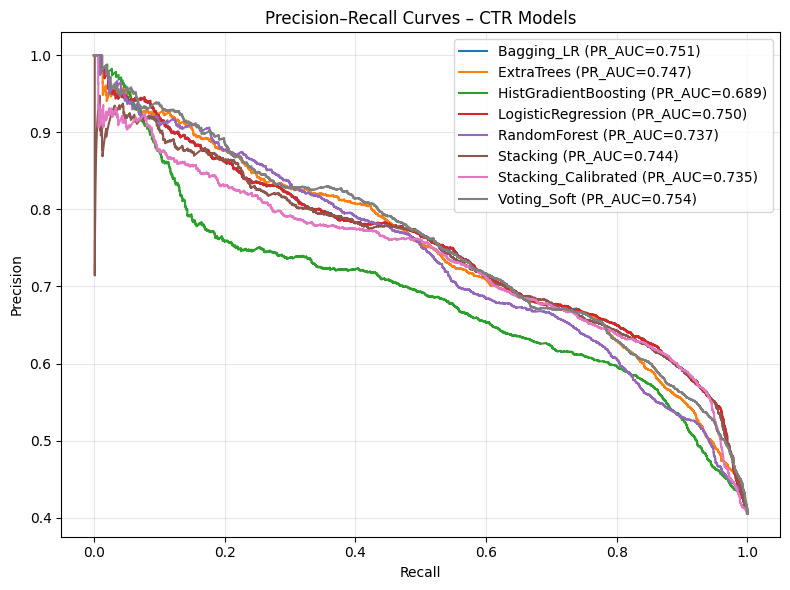

Saved figure: d:\projects\Ai\project_fusion_ecu\data\processed\figures_eval\pr_curves.png

Precision@K:
                   Model     K  Precision@K
0            Voting_Soft   500       0.9280
1             ExtraTrees   500       0.9260
2           RandomForest   500       0.9120
3             Bagging_LR   500       0.9080
4     LogisticRegression   500       0.9080
5               Stacking   500       0.8860
6    Stacking_Calibrated   500       0.8740
7   HistGradientBoosting   500       0.8620
8             ExtraTrees  1000       0.8720
9           RandomForest  1000       0.8710
10           Voting_Soft  1000       0.8690
11              Stacking  1000       0.8630
12            Bagging_LR  1000       0.8590
13    LogisticRegression  1000       0.8590
14   Stacking_Calibrated  1000       0.8300
15  HistGradientBoosting  1000       0.7640
16           Voting_Soft  2000       0.8145
17            ExtraTrees  2000       0.8080
18          RandomForest  2000       0.7955
19              

In [4]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import load_npz, issparse
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    log_loss,
)

# ===============================
# Paths
# ===============================
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
processed_dir = os.path.join(project_root, "data", "processed")
models_dir = os.path.join(project_root, "models")
fig_dir = os.path.join(processed_dir, "figures_eval")
os.makedirs(fig_dir, exist_ok=True)

X_test_path = os.path.join(processed_dir, "X_test_processed.npz")
y_test_path = os.path.join(processed_dir, "y_test.csv")

if not os.path.exists(X_test_path):
    raise FileNotFoundError(X_test_path)
if not os.path.exists(y_test_path):
    raise FileNotFoundError(y_test_path)

# Outputs
results_csv = os.path.join(processed_dir, "final_evaluation_results.csv")
rank_csv = os.path.join(processed_dir, "precision_at_k.csv")
best_thr_json = os.path.join(processed_dir, "best_threshold.json")

# ===============================
# Load data
# ===============================
X_test_sparse = load_npz(X_test_path).tocsr()
y_test = pd.read_csv(y_test_path).squeeze().astype(int)

print("X_test shape:", X_test_sparse.shape, "sparse:", issparse(X_test_sparse))
print("y_test distribution:")
print(y_test.value_counts(normalize=True))

# Build ONE dense copy (only if needed by some models)
X_test_dense = None  # create lazily


# ===============================
# Helpers (ONLY project metrics)
# ===============================
def safe_predict_proba(model, X):
    """Return positive-class probabilities safely."""
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        if p.ndim == 2 and p.shape[1] >= 2:
            return p[:, 1]
        return p.reshape(-1)
    if hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        return 1.0 / (1.0 + np.exp(-scores))
    raise AttributeError(f"{model.__class__.__name__} has no predict_proba/decision_function")

def best_threshold_by_f1(y_true, probas):
    """Compute BestThr_F1 and F1_at_best (+ precision/recall at best)."""
    precision, recall, thresholds = precision_recall_curve(y_true, probas)
    # last precision/recall has no threshold
    precision = precision[:-1]
    recall = recall[:-1]
    f1 = (2 * precision * recall) / (precision + recall + 1e-12)
    best_idx = int(np.nanargmax(f1))
    return float(thresholds[best_idx]), float(f1[best_idx]), float(precision[best_idx]), float(recall[best_idx])

def precision_at_k(y_true, probas, k):
    """Precision@K used by your project (ranking metric)."""
    k = int(min(k, len(y_true)))
    idx = np.argsort(-probas)[:k]
    return float(y_true.iloc[idx].mean())

def try_load_model(path):
    try:
        return joblib.load(path)
    except Exception as e:
        print(f"[SKIP] failed to load {os.path.basename(path)}: {e}")
        return None

def get_expected_n_features(model):
    """Infer expected number of features (to catch mismatch)."""
    if hasattr(model, "n_features_in_"):
        return int(model.n_features_in_)

    # CalibratedClassifierCV: check inner estimator
    if hasattr(model, "calibrated_classifiers_") and len(model.calibrated_classifiers_) > 0:
        try:
            base = model.calibrated_classifiers_[0].estimator
            if hasattr(base, "n_features_in_"):
                return int(base.n_features_in_)
        except Exception:
            pass

    return None

def predict_with_auto_dense(model, X_sparse, X_dense_cached):
    """
    Try sparse first. If model requires dense, retry with dense.
    Returns (probas, used_dense, dense_cache)
    """
    try:
        probas = safe_predict_proba(model, X_sparse)
        return probas, False, X_dense_cached
    except (TypeError, ValueError) as e:
        msg = str(e).lower()
        if ("dense data is required" in msg) or ("sparse data was passed" in msg):
            if X_dense_cached is None:
                X_dense_cached = X_sparse.toarray().astype(np.float32)
                print("  [info] Built X_test_dense (float32) because a model requires dense input.")
            probas = safe_predict_proba(model, X_dense_cached)
            return probas, True, X_dense_cached
        raise

def sanitize_probas(probas):
    """Make probas safe for LogLoss / PR / ROC."""
    probas = np.asarray(probas).reshape(-1)
    # replace NaNs/infs
    probas = np.nan_to_num(probas, nan=0.5, posinf=1.0, neginf=0.0)
    # clip away from 0/1 for logloss stability
    probas = np.clip(probas, 1e-6, 1 - 1e-6)
    return probas


# ===============================
# Build model list dynamically
# ===============================
model_names = []
if not os.path.isdir(models_dir):
    raise FileNotFoundError(models_dir)

for fn in os.listdir(models_dir):
    if fn.endswith("_model.pkl"):
        model_names.append(fn.replace("_model.pkl", ""))

model_names = sorted(model_names)
print("\nModels found:")
print(model_names)

# ===============================
# Evaluate models (ONLY your metrics)
# ===============================
results = []
roc_curves = []
pr_curves = []

X_test_n = X_test_sparse.shape[1]

for name in model_names:
    model_path = os.path.join(models_dir, f"{name}_model.pkl")
    model = try_load_model(model_path)
    if model is None:
        continue

    expected_n = get_expected_n_features(model)
    if expected_n is not None and expected_n != X_test_n:
        print(f"[SKIP] {name}: feature mismatch. expects {expected_n}, X_test has {X_test_n}. Retrain this model.")
        continue

    # Predict (auto choose sparse/dense)
    try:
        probas, used_dense, X_test_dense = predict_with_auto_dense(model, X_test_sparse, X_test_dense)
        probas = sanitize_probas(probas)
    except Exception as e:
        print(f"[SKIP] {name}: predict failed -> {e}")
        continue

    # Metrics (project-only)
    auc = roc_auc_score(y_test, probas)
    pr_auc = average_precision_score(y_test, probas)
    ll = log_loss(y_test, probas)

    thr, best_f1, p_best, r_best = best_threshold_by_f1(y_test, probas)

    results.append({
        "Model": name,
        "InputUsed": "dense" if used_dense else "sparse",
        "ROC_AUC": float(auc),
        "LogLoss": float(ll),
        "PR_AUC": float(pr_auc),
        "BestThr_F1": float(thr),
        "F1_at_best": float(best_f1),
        "Precision_at_best": float(p_best),
        "Recall_at_best": float(r_best),
        "n_features": int(X_test_n),
    })

    # Curves (project visuals)
    fpr, tpr, _ = roc_curve(y_test, probas)
    roc_curves.append((name, fpr, tpr, auc))

    precision, recall, _ = precision_recall_curve(y_test, probas)
    pr_curves.append((name, recall, precision, pr_auc))

# ===============================
# Results table
# ===============================
results_df = pd.DataFrame(results)
if results_df.empty:
    raise RuntimeError("No models evaluated. Check models_dir, or all models mismatched features.")

# Sort by your typical priority (PR_AUC often good for CTR)
results_df = results_df.sort_values("PR_AUC", ascending=False).reset_index(drop=True)

print("\nFinal Evaluation Results:")
print(results_df)

results_df.to_csv(results_csv, index=False)
print("Saved:", results_csv)

# ===============================
# Save best threshold JSON (for Streamlit)
# Choose the model with highest F1_at_best
# ===============================
best_row = results_df.sort_values("F1_at_best", ascending=False).iloc[0]
best_obj = {
    "model": str(best_row["Model"]),
    "best_threshold_f1": float(best_row["BestThr_F1"]),
    "f1_at_best": float(best_row["F1_at_best"]),
    "precision_at_best": float(best_row["Precision_at_best"]),
    "recall_at_best": float(best_row["Recall_at_best"]),
}
with open(best_thr_json, "w", encoding="utf-8") as f:
    json.dump(best_obj, f, indent=2)
print("Saved:", best_thr_json)

# ===============================
# ROC Curves plot
# ===============================
plt.figure(figsize=(8, 6))
for name, fpr, tpr, auc in roc_curves:
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – CTR Models")
plt.legend()
plt.grid(alpha=0.3)
roc_path = os.path.join(fig_dir, "roc_curves.png")
plt.tight_layout()
plt.savefig(roc_path, dpi=160)
plt.show()
print("Saved figure:", roc_path)

# ===============================
# PR Curves plot
# ===============================
plt.figure(figsize=(8, 6))
for name, recall, precision, pr_auc in pr_curves:
    plt.plot(recall, precision, label=f"{name} (PR_AUC={pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – CTR Models")
plt.legend()
plt.grid(alpha=0.3)
pr_path = os.path.join(fig_dir, "pr_curves.png")
plt.tight_layout()
plt.savefig(pr_path, dpi=160)
plt.show()
print("Saved figure:", pr_path)

# ===============================
# Precision@K (project metric)
# ===============================
rank_rows = []
Ks = [500, 1000, 2000, 5000]

for name in results_df["Model"].tolist():
    model_path = os.path.join(models_dir, f"{name}_model.pkl")
    model = try_load_model(model_path)
    if model is None:
        continue

    # auto sparse/dense again
    probas, _, X_test_dense = predict_with_auto_dense(model, X_test_sparse, X_test_dense)
    probas = sanitize_probas(probas)

    for k in Ks:
        rank_rows.append({
            "Model": name,
            "K": int(min(k, len(y_test))),
            "Precision@K": precision_at_k(y_test, probas, k),
        })

rank_df = pd.DataFrame(rank_rows).sort_values(["K", "Precision@K"], ascending=[True, False]).reset_index(drop=True)
print("\nPrecision@K:")
print(rank_df)

rank_df.to_csv(rank_csv, index=False)
print("Saved:", rank_csv)

print("\n[Evaluation completed successfully.]")


### Modifications Summary
This evaluation notebook has been updated to align with the revised preprocessing and training stages.
It now loads the processed test matrix (`X_test_processed.npz`) and associated labels.
Model performance is assessed using ROC-AUC, LogLoss, and PR-AUC metrics only. Accuracy and F1-score have been removed to provide more informative evaluation for imbalanced classification.
